In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict

In [2]:
ne_train = pd.read_csv("ne_train.csv")
ne_test = pd.read_csv("ne_test_new.csv")

s_train = pd.read_csv("s_train.csv")
s_test = pd.read_csv("s_test.csv")

In [133]:
ne_train = ne_train[ne_train['covid_19_confirmed_cases'] != 0]

### Picking Columns for XGBoost

In [134]:
# covid-19 lagged columns, remove age columns
# xgboost works for categorical and numerical variables
# for grade columns -> choose A, C, and F to slim it down, and as those would provide the best, worst, and middle
# remove true and false columns
ne_train.columns

Index(['date', 'cat__social_distancing_total_grade_B',
       'cat__social_distancing_total_grade_C',
       'cat__social_distancing_total_grade_C+',
       'cat__social_distancing_total_grade_C-',
       'cat__social_distancing_total_grade_D',
       'cat__social_distancing_total_grade_D+',
       'cat__social_distancing_total_grade_F',
       'cat__social_distancing_visitation_grade_A',
       'cat__social_distancing_visitation_grade_F',
       'cat__social_distancing_encounters_grade_A',
       'cat__social_distancing_encounters_grade_F',
       'cat__social_distancing_travel_distance_grade_B',
       'cat__social_distancing_travel_distance_grade_C',
       'cat__social_distancing_travel_distance_grade_D',
       'cat__social_distancing_travel_distance_grade_F',
       'num__daily_state_test', 'num__precipitation', 'num__temperature',
       'num__total_population', 'num__female_percent', 'num__area',
       'num__population_density', 'num__latitude', 'num__longitude',
       'num__

In [4]:
ne_columns = ['num__daily_state_test', 'num__precipitation',
       'num__temperature', 'num__total_population',
       'num__population_density', 'num__hospital_beds_ratio',
       'num__ventilator_capacity_ratio', 'num__icu_beds_ratio',
       'num__houses_density', 'num__less_than_high_school_diploma',
       'num__high_school_diploma_only',
       'num__total_college_population', 'num__percent_smokers',
       'num__percent_diabetes', 'num__Religious_congregation_ratio',
       'num__political_party', 'num__airport_distance',
       'num__median_household_income', 'num__percent_insured', 
       'num__gdp_per_capita']

In [5]:
X_train_ne = ne_train[ne_columns]
y_train_ne = ne_train['covid_19_confirmed_cases']

X_test_ne = ne_test[ne_columns]
y_test_ne = ne_test['covid_19_confirmed_cases']


X_train_s = s_train[ne_columns]
y_train_s = s_train['covid_19_confirmed_cases']

X_test_s = s_test[ne_columns]
y_test_s = s_test['covid_19_confirmed_cases']

## Model Building - NE

### XGBoost Tuning

In [7]:
param_grid = {'max_depth': [2,5,10,15],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

In [152]:
split = TimeSeriesSplit(n_splits = 5)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 50,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train_ne,y_train_ne)
print("Optimal parameter values =", optimal_params.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 10, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 1.0}


In [142]:
model = xgb.XGBRegressor(max_depth = 2, learning_rate = 0.01,
                        n_estimators = 500,reg_lambda = 10, gamma = 100, subsample = 0.75, colsample_bytree = 1)
model.fit(X_train_ne, y_train_ne, eval_set = ([(X_test_ne, y_test_ne)]), early_stopping_rounds = 100)

[0]	validation_0-rmse:2260.44994
[1]	validation_0-rmse:2152.90890
[2]	validation_0-rmse:2037.89824
[3]	validation_0-rmse:1906.90423
[4]	validation_0-rmse:1793.91169
[5]	validation_0-rmse:1697.30614
[6]	validation_0-rmse:1614.00988
[7]	validation_0-rmse:1559.21225
[8]	validation_0-rmse:1515.63928
[9]	validation_0-rmse:1465.17757
[10]	validation_0-rmse:1434.78832
[11]	validation_0-rmse:1398.74217
[12]	validation_0-rmse:1374.24321
[13]	validation_0-rmse:1350.37528
[14]	validation_0-rmse:1311.51978
[15]	validation_0-rmse:1297.23939
[16]	validation_0-rmse:1282.39982
[17]	validation_0-rmse:1257.42708
[18]	validation_0-rmse:1250.15754
[19]	validation_0-rmse:1243.56721
[20]	validation_0-rmse:1236.06056
[21]	validation_0-rmse:1224.62666
[22]	validation_0-rmse:1221.21531
[23]	validation_0-rmse:1210.71816
[24]	validation_0-rmse:1207.59937
[25]	validation_0-rmse:1204.43112
[26]	validation_0-rmse:1210.41568
[27]	validation_0-rmse:1218.22986
[28]	validation_0-rmse:1215.52939
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
pred_ne = model.predict(X_test_ne)
ne_test['pred'] = pred_ne

Text(0.5, 1.0, ' NE - XGBoost Model Predictions vs Actual')

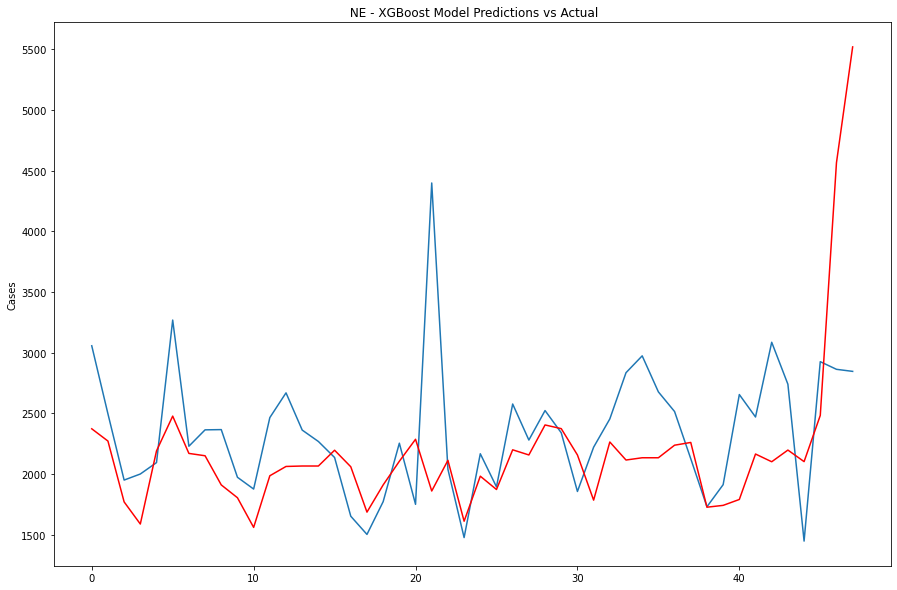

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(ne_test.covid_19_confirmed_cases, label='Actual')
plt.plot(ne_test.pred, label='Predicted',color = "red")

plt.ylabel('Cases')
plt.title(f' NE - XGBoost Model Predictions vs Actual')

In [145]:
mean_absolute_error(y_test_ne, ne_test.pred)

801.6329625447592

<Figure size 1080x576 with 0 Axes>

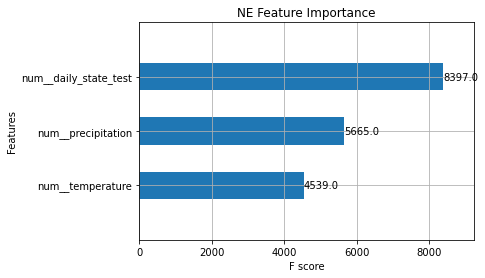

In [29]:
plt.figure(figsize = (15, 8))
plot_importance(optimal_params.best_estimator_, height = 0.5)
plt.title("NE Feature Importance")
plt.show()

### Model Building - South

In [11]:
cv = TimeSeriesSplit(n_splits = 5)
optimal_params = RandomizedSearchCV(estimator = xgb.XGBRegressor(random_state = 1),                                                       
                             param_distributions = param_grid, n_iter = 50,
                             verbose = 1,
                             n_jobs = -1,
                             cv = cv)
optimal_params.fit(X_train_s,y_train_s)
print("Optimal parameter values =", optimal_params.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.75}


In [22]:
model = xgb.XGBRegressor(max_depth = 5, learning_rate = 0.05,
                        n_estimators = 1000 ,reg_lambda = 0, gamma = 0, subsample = 0.5, colsample_bytree = 0.75)
model.fit(X_train_s, y_train_s, eval_set = ([(X_test_s, y_test_s)]), early_stopping_rounds = 100)

[0]	validation_0-rmse:16484.71721
[1]	validation_0-rmse:15460.26192
[2]	validation_0-rmse:14750.66417
[3]	validation_0-rmse:13822.01295
[4]	validation_0-rmse:12954.28350
[5]	validation_0-rmse:12155.37417
[6]	validation_0-rmse:11564.89621
[7]	validation_0-rmse:11097.04422
[8]	validation_0-rmse:10395.71278
[9]	validation_0-rmse:9898.21089
[10]	validation_0-rmse:9278.88669
[11]	validation_0-rmse:8840.62182
[12]	validation_0-rmse:8396.99395
[13]	validation_0-rmse:7894.51895
[14]	validation_0-rmse:7462.20633
[15]	validation_0-rmse:7229.09712
[16]	validation_0-rmse:6929.56876
[17]	validation_0-rmse:6575.01361
[18]	validation_0-rmse:6300.42348
[19]	validation_0-rmse:5953.41648
[20]	validation_0-rmse:5651.46711
[21]	validation_0-rmse:5521.33093
[22]	validation_0-rmse:5278.24731
[23]	validation_0-rmse:5026.11127
[24]	validation_0-rmse:4891.62804
[25]	validation_0-rmse:4818.69502
[26]	validation_0-rmse:4661.34466
[27]	validation_0-rmse:4596.29313
[28]	validation_0-rmse:4512.81397
[29]	validation

/Users/lalla-aichaadouim/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:4079.40259
[34]	validation_0-rmse:4046.83706
[35]	validation_0-rmse:4026.89102
[36]	validation_0-rmse:4011.18807
[37]	validation_0-rmse:4001.41699
[38]	validation_0-rmse:4000.15053
[39]	validation_0-rmse:3985.43674
[40]	validation_0-rmse:4009.26656
[41]	validation_0-rmse:4024.06847
[42]	validation_0-rmse:4052.60818
[43]	validation_0-rmse:4070.22414
[44]	validation_0-rmse:4086.11689
[45]	validation_0-rmse:4113.32852
[46]	validation_0-rmse:4140.93815
[47]	validation_0-rmse:4173.50508
[48]	validation_0-rmse:4215.25085
[49]	validation_0-rmse:4247.17953
[50]	validation_0-rmse:4279.26681
[51]	validation_0-rmse:4310.58903
[52]	validation_0-rmse:4315.26396
[53]	validation_0-rmse:4335.68356
[54]	validation_0-rmse:4366.61881
[55]	validation_0-rmse:4402.95905
[56]	validation_0-rmse:4435.83911
[57]	validation_0-rmse:4462.64132
[58]	validation_0-rmse:4487.06271
[59]	validation_0-rmse:4515.43101
[60]	validation_0-rmse:4535.91548
[61]	validation_0-rmse:4575.41454
[62]	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
pred_s = model.predict(X_test_s)
s_test['pred'] = pred_s

Text(0.5, 1.0, 'South - XGBoost Model Predictions vs Actual')

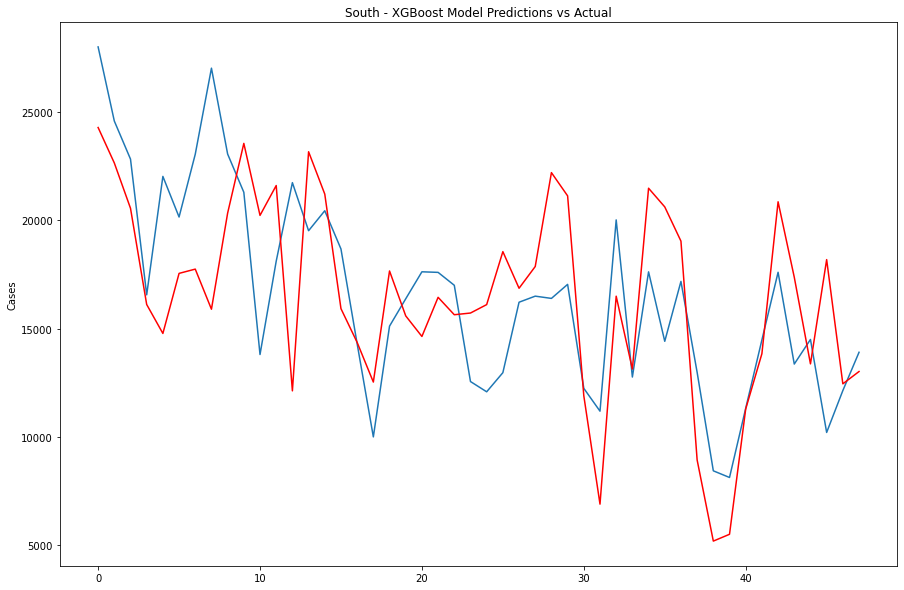

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(s_test.covid_19_confirmed_cases, label='Actual')
plt.plot(s_test.pred, label='Predicted',color = "red")

plt.ylabel('Cases')
plt.title(f'South - XGBoost Model Predictions vs Actual')

In [26]:
mean_absolute_error(y_test_s, s_test.pred)

3142.532023111979

<Figure size 1080x576 with 0 Axes>

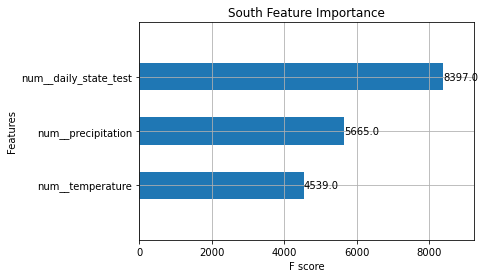

In [28]:
plt.figure(figsize = (15, 8))
plot_importance(optimal_params.best_estimator_, height = 0.5)
plt.title("South Feature Importance")
plt.show()